**Author**: Roman Okhrimchuk, Geospatial Data Scientist, [LinkedIn](https://www.linkedin.com/in/roman-okhrimchuk/)

#### Importing Required Libraries ¶

We begin by importing essential Python libraries for handling raster and satellite data. In particular:

- **numpy**: A fundamental package for numerical computations, especially useful for handling arrays and performing mathematical operations.
- **xarray**: A library for working with labeled multi-dimensional arrays, commonly used for satellite data in NetCDF format.
- **rasterio**: A library to read and write geospatial raster datasets (e.g., GeoTIFF), built on top of GDAL.
- **geopandas**: Adds support for geographic data to pandas, making it easier to work with shapefiles.
- **rasterio.mask**: A submodule of rasterio that allows masking raster data with vector geometries.
- **matplotlib.pyplot**: A versatile plotting library used for visualizing raster layers, time series, and spatial patterns.
- **lexcube**: A library for 3D visualization of Earth observation data cubes, supporting interactive exploration of spatiotemporal datasets.
> M. Söchting, M. D. Mahecha, D. Montero and G. Scheuermann, "Lexcube: Interactive Visualization of Large Earth System Data Cubes," in IEEE Computer Graphics and Applications, vol. 44, no. 1, pp. 25-37, Jan.-Feb. 2024, doi: 10.1109/MCG.2023.3321989
>


These libraries support reading, manipulating, and visualizing raster data, making them essential for remote sensing workflows.

In [ ]:
import lexcube 
import numpy as np
import xarray as xr
import rasterio as rio
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt


#### Defining input data paths ¶

This section specifies the file paths to the input datasets used in the analysis. The data includes:

- **Administrative boundaries** of Kyiv stored in GeoJSON format.
- **Landsat 9 satellite imagery** covering bands 1–7 and band 10, provided as a GeoTIFF file.
- **ERA5 weather model outputs** in NetCDF format, including:
  - Accumulated values for Surface Solar Radiation Downwards (SSRD) and Total Precipitation (TP).
  - Instantaneous values for 2-meter Air Temperature (T2M).

These datasets are used in subsequent steps for spatial masking, raster processing, and climate-related assessments.

In [21]:
boundary_vector_path = r"..\data\vectors\Kyiv.geojson"

era5_accum_raster_path = r'..\data\rasters\weather_model\ERA5_SSRD_TP_Apr_2025_accum.nc'
era5_instant_raster_path =  r'..\data\rasters\weather_model\ERA5_T2M_Apr_2025_instant.nc'
landsat_raster_path = r"..\data\rasters\satellite_imagery\LC09_L2SP_181025_20250425_20250426_02_T1_SR_B1-10_small.tif"

#### Image preprocessing functions ¶

This section defines helper functions for:

- Scaling 16-bit satellite bands to float32.
- Calculating the Normalized Difference Built-up Index (NDBI) from SWIR and NIR bands.

In [28]:
def scale_uint16_to_float(band):
    """
    Scale a uint16 image band to float32 in the range [0.0, 1.0],
    assuming the maximum value is 65535.

    Parameters:
        band (np.ndarray): Input image band as a NumPy array (dtype=uint16).

    Returns:
        np.ndarray: Scaled band as float32.
    """
    return band.astype(np.float32) / 65535.0

def calculate_ndbi(swir_band, nir_band):
    """
    The Normalized Difference Built-up Index (NDBI) uses the NIR and SWIR bands 
    to emphasize manufactured built-up areas. 
    It is ratio based to mitigate the effects of terrain illumination differences 
    as well as atmospheric effects. 
    Calculate NDBI using the formula:
    NDBI = (SWIR - NIR) / (SWIR + NIR)

    Parameters:
        swir_band (np.ndarray): Short-Wave Infrared band (e.g. Band 6)
        nir_band (np.ndarray): Near-Infrared band (e.g. Band 5)

    Returns:
        np.ndarray: NDBI values as float32, with NaN where undefined
    """
    swir = swir_band.astype(np.float32)
    nir = nir_band.astype(np.float32)
    ndbi = (swir - nir) / (swir + nir)

    # Avoid division by zero
    ndbi[(swir + nir) == 0] = np.nan
    return ndbi


#### Grayscale Visualization of Landsat 9 Spectral Bands (1–7, 10) ¶

This section visualizes selected bands from a Landsat 9 surface reflectance image (atmospherically corrected).  
Bands are displayed in grayscale to highlight spatial differences in reflectance.

**Band descriptions:**

- **Band 1** – Coastal aerosol (ultra-blue), useful for coastal and atmospheric studies.  
- **Band 2** – Blue, sensitive to water and shallow features.  
- **Band 3** – Green, used for assessing vegetation health.  
- **Band 4** – Red, useful for vegetation and urban contrast.  
- **Band 5** – Near-Infrared (NIR), highlights vegetation and biomass.  
- **Band 6** – Short-Wave Infrared 1 (SWIR1), detects soil and moisture.  
- **Band 7** – Short-Wave Infrared 2 (SWIR2), useful for geological features.  
- **Band 10** – Thermal Infrared (TIRS1), used for land surface temperature.

Total bands in the file: 8


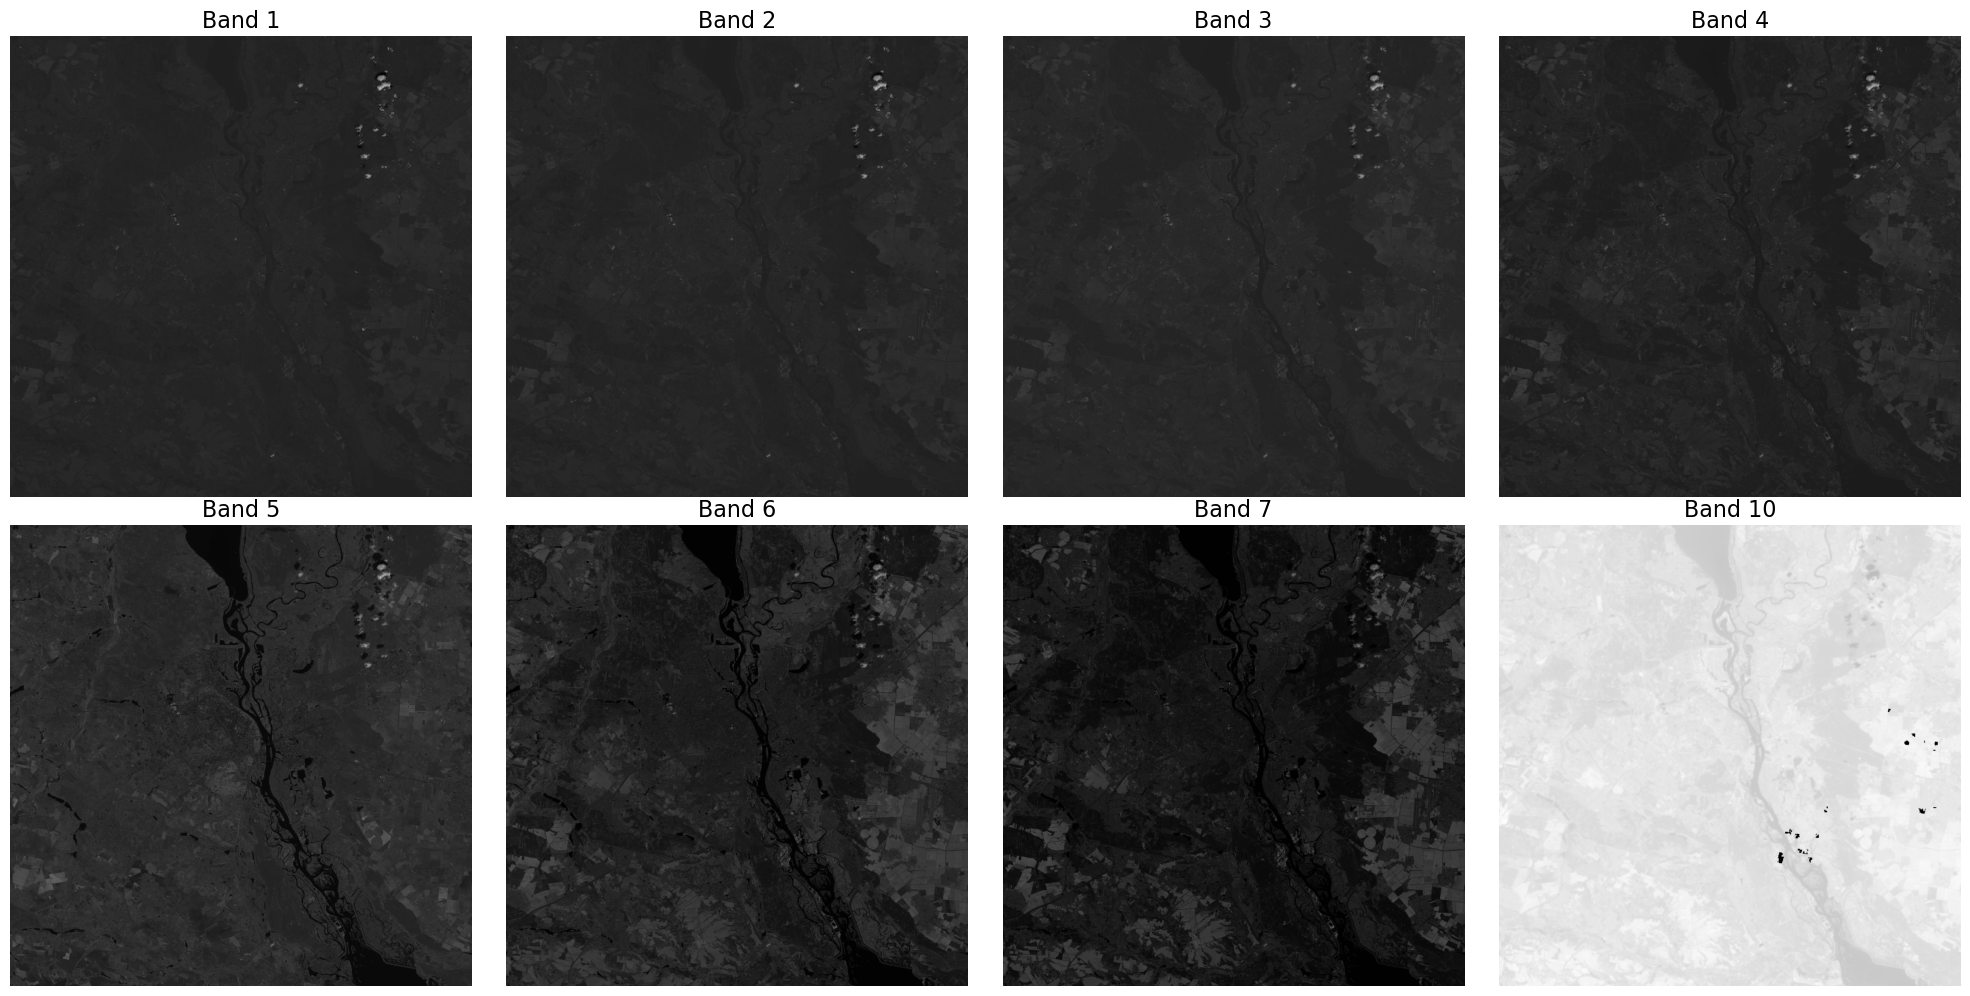

In [29]:
with rio.open(landsat_raster_path) as src:
    # Get total number of bands
    band_count = src.count
    print(f"Total bands in the file: {band_count}")

    # Define bands to plot: Landsat 9 bands 1–7 + Band 10 (stored as band 8)
    bands_to_plot = list(range(1, 9))  # 1 to 8

    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, band_num in enumerate(bands_to_plot):
        band = src.read(band_num)
        ax = axs[i // 4, i % 4]
        ax.imshow(band, cmap='gray')

        # Band 8 in the file actually corresponds to Landsat Band 10 → relabel for clarity
        display_name = "Band 10" if band_num == 8 else f"Band {band_num}"
        ax.set_title(display_name, fontsize=16)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### True-Color RGB Composite (Bands 4–3–2) without normalization ¶

This section visualizes a **true-color composite** of a Landsat 9 surface reflectance image using bands:

- **Red**: Band 4  
- **Green**: Band 3  
- **Blue**: Band 2




##### ⚠️ Display Note

`matplotlib.pyplot.imshow()` does **not** handle `uint16` image data correctly by default.  
This is because it expects input pixel values in one of the following ranges:

- **0–255** for `uint8` images  
- **0.0–1.0** for `float32` images  

However, **Landsat surface reflectance data** is in `uint16` format with values ranging from **0 to 65535**

>As a result, the image will appear completely `white or blank` when plotted directly **without normalization**:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


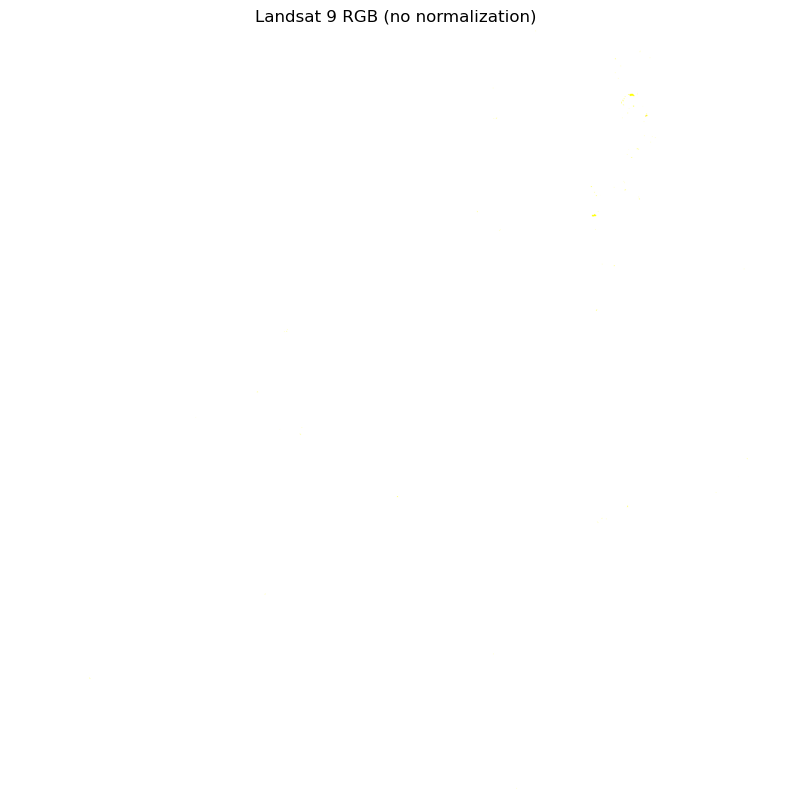

In [30]:
# Read the multi-band Landsat 9 GeoTIFF

with rio.open(landsat_raster_path) as src:
    # Read bands: Red (4), Green (3), Blue (2)
    red = src.read(4)
    green = src.read(3)
    blue = src.read(2)

# Stack RGB bands into a 3D array
rgb = np.stack([red, green, blue], axis=-1)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')
plt.title("Landsat 9 RGB (no normalization)")
plt.show()

#### True-Color RGB Composite (Bands 4–3–2) with normalization ¶

This section displays a true-color RGB composite of a Landsat 9 surface reflectance image, using:

- **Red**: Band 4  
- **Green**: Band 3  
- **Blue**: Band 2

Since the original data is in `uint16` format with values ranging from **0 to 65535**, each band is scaled to `float32` in the range **[0.0, 1.0]**

> This normalized rendering preserves natural color appearance and avoids brightness saturation:

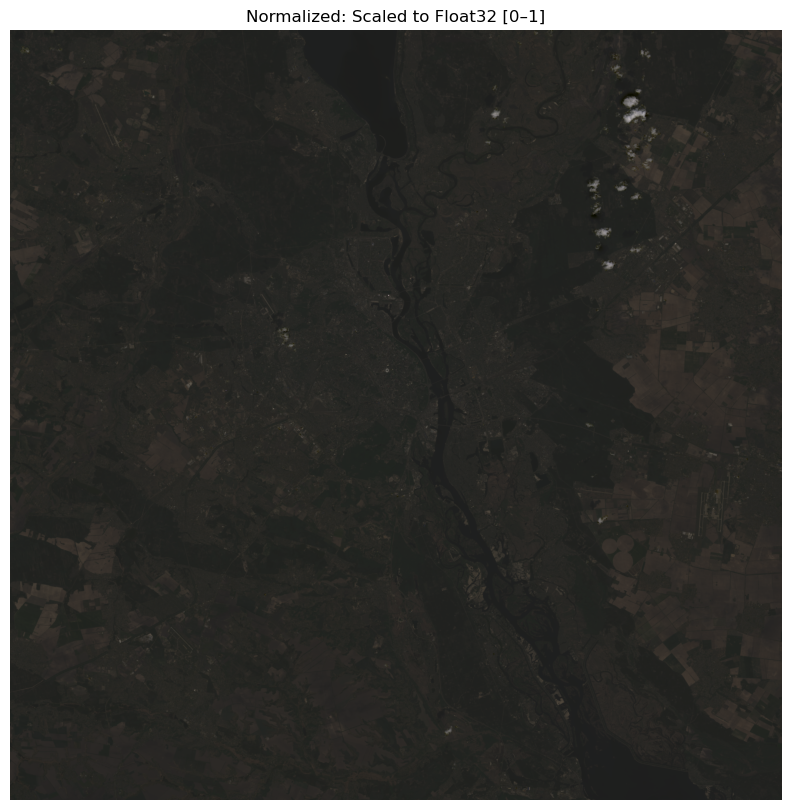

In [31]:
# Read the multi-band Landsat 9 GeoTIFF

with rio.open(landsat_raster_path) as src:
    # Read bands: Red (4), Green (3), Blue (2)
    red = scale_uint16_to_float(src.read(4))
    green = scale_uint16_to_float(src.read(3))
    blue = scale_uint16_to_float(src.read(2))

# Stack RGB bands into a 3D array
rgb = np.stack([red, green, blue], axis=-1)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.axis('off')
plt.title("Normalized: Scaled to Float32 [0–1]")
plt.show()


#### Masked True-Color RGB Composite over Kyiv

This section displays a true-color RGB composite (Bands 4–3–2) from the Landsat 9 surface reflectance image,  
masked to the administrative boundaries of Kyiv.

The process involves:

- Loading the Kyiv boundary from a GeoJSON file.
- Reprojecting the vector layer to match the raster’s coordinate reference system (CRS).
- Masking the raster image using the Kyiv boundary geometry (`rasterio.mask.mask`).
- Extracting Red (Band 4), Green (Band 3), and Blue (Band 2) bands from the masked output.
- Scaling each band from `uint16` to `float32` in the range [0, 1] for proper visualization.
- Stacking the bands into an RGB array and displaying the result.

> The final image shows a masked and normalized Landsat 9 RGB composite focused on Kyiv

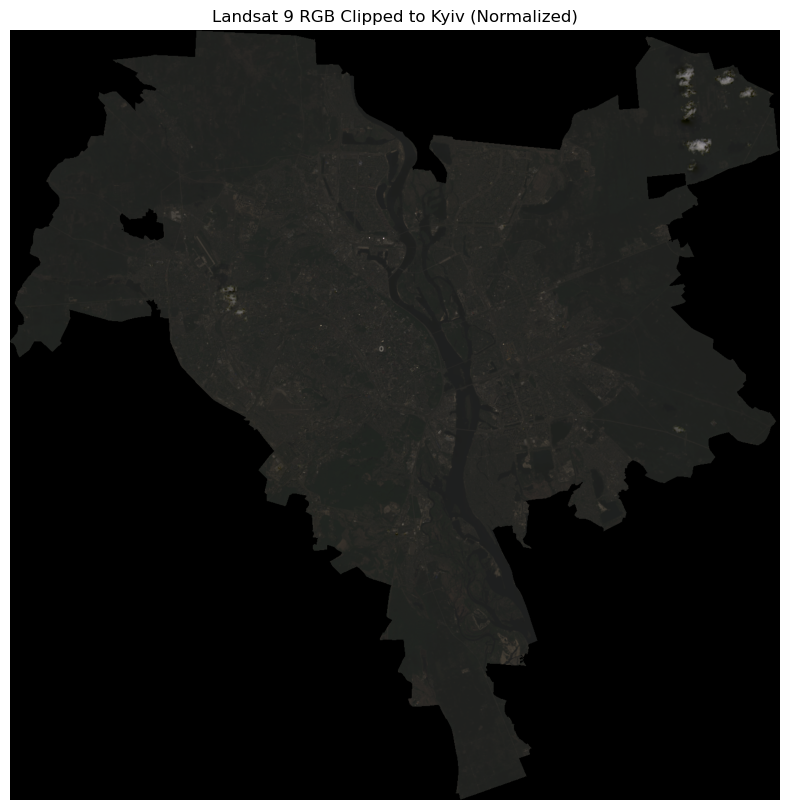

In [32]:
# Read Kyiv boundary 
gdf = gpd.read_file(boundary_vector_path)
 
# Read raster and reproject vector to match raster CRS 

with rio.open(landsat_raster_path) as src:
    gdf = gdf.to_crs(src.crs)  # Reproject vector to match raster

    # Crop raster to Kyiv geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    red = scale_uint16_to_float(out_image[3])  # Band 4
    green = scale_uint16_to_float(out_image[2])  # Band 3
    blue = scale_uint16_to_float(out_image[1])  # Band 2

# Stack RGB and mask NoData
rgb = np.stack([red, green, blue], axis=-1)

# Plot 
plt.figure(figsize=(10, 10))
plt.imshow(rgb)

plt.axis('off')
plt.title("Landsat 9 RGB Clipped to Kyiv (Normalized)")
plt.show()

#### NDBI Calculation and visualization

This section computes and visualizes the **Normalized Difference Built-up Index (NDBI)**  
using Bands 6 (SWIR1) and 5 (NIR) from the Landsat 9 surface reflectance image.

**NDBI formula:**
NDBI = (SWIR - NIR) / (SWIR + NIR)


**Steps:**

- Load Band 6 (Short-Wave Infrared 1) and Band 5 (Near-Infrared).
- Apply the NDBI formula using a predefined helper function.
- Visualize the result using a diverging color map (`RdBu`), with values scaled from **–1 to 1**.

> NDBI helps highlight built-up and urbanized areas, where higher values typically indicate impervious surfaces like concrete or or rooftops

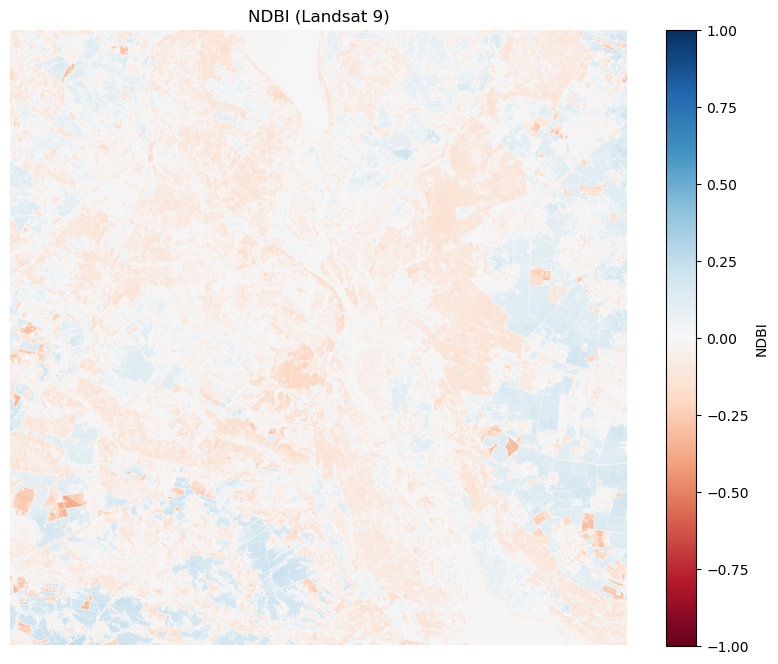

In [37]:
# Read the multi-band Landsat 9 image 
with rio.open(landsat_raster_path) as src:
    # Read Band 6 (SWIR1) and Band 5 (NIR)
    swir = src.read(6)  # Short-Wave Infrared
    nir = src.read(5)   # Near-Infrared

# Compute NDBI 
ndbi = calculate_ndbi(swir, nir)

# Visualize NDBI using a diverging color map 
plt.figure(figsize=(10, 8))
plt.imshow(ndbi, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label="NDBI")
plt.title("NDBI (Landsat 9)")
plt.axis('off')
plt.show()

#### NDBI Masked to Kyiv boundary 

This section computes and visualizes the **Normalized Difference Built-up Index (NDBI)**  
within the administrative boundary of **Kyiv**, using a masked subset of the Landsat 9 image.

**Steps:**

- Load the Kyiv boundary polygon from a GeoJSON file.
- Reproject the polygon to match the raster CRS.
- Apply a spatial mask to extract only the portion of the raster that intersects Kyiv.
- Extract Band 6 (SWIR1) and Band 5 (NIR) from the masked image.
- Calculate the NDBI using the formula:
NDBI = (SWIR - NIR) / (SWIR + NIR)


- Visualize the NDBI using a diverging color scale (`RdBu`), clipped to the range **[–1, 1]**.

> This output highlights built-up areas within Kyiv and removes irrelevant surroundings from the raster extent

C:\Users\Roma\AppData\Local\Temp\ipykernel_17116\2828599970.py:32: RuntimeWarning: invalid value encountered in divide
  ndbi = (swir - nir) / (swir + nir)


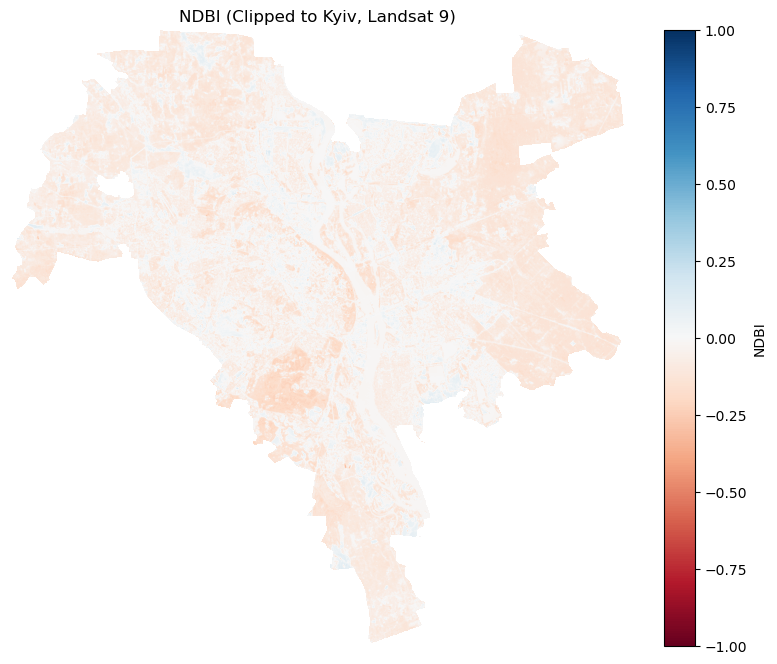

In [40]:
# Read Kyiv polygon 
gdf = gpd.read_file(boundary_vector_path)

# Read Landsat 9 image and clip to Kyiv 

with rio.open(landsat_raster_path) as src:
    # Reproject Kyiv polygon to raster CRS
    gdf = gdf.to_crs(src.crs)

    # Mask raster by polygon (crop=True removes outside area)
    out_image, out_transform = mask(src, gdf.geometry, crop=True)

    # Extract required bands for NDBI: SWIR = Band 6, NIR = Band 5
    swir = out_image[5]  # Band 6 (index 5)
    nir = out_image[4]   # Band 5 (index 4)

#  Compute NDBI 
ndbi = calculate_ndbi(swir, nir)

#  Visualize NDBI 
plt.figure(figsize=(10, 8))
plt.imshow(ndbi, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label="NDBI")
plt.title("NDBI (Clipped to Kyiv, Landsat 9)")
plt.axis('off')
plt.show()

#### NDBI Visualization with quantile stretching (2–98%)

This section enhances the NDBI visualization by applying **quantile-based contrast stretching**,  
which helps emphasize meaningful variation and suppress extreme outliers.

**Steps:**

- Compute the `2nd and 98th` percentiles (`vmin`, `vmax`) of the NDBI distribution.
- Clip NDBI values to this range using `np.clip()`.
- Display the clipped image with the `RdBu` diverging colormap.
- Add a colorbar and clear background using `axis('off')`.

> This approach improves visual interpretation of urban versus non-urban areas by increasing contrast within the main data range while avoiding distortion from extreme values

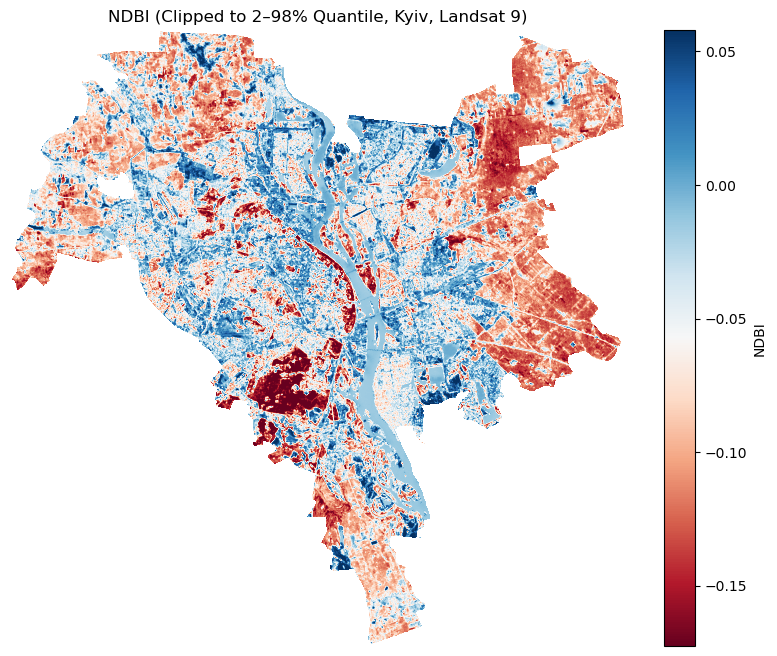

In [41]:
vmin = np.nanpercentile(ndbi, 2)
vmax = np.nanpercentile(ndbi, 98)
ndbi_clipped = np.clip(ndbi, vmin, vmax)

plt.figure(figsize=(10, 8))
plt.imshow(ndbi_clipped, cmap='RdBu', vmin=vmin, vmax=vmax)
plt.colorbar(label="NDBI")
plt.title("NDBI (Clipped to 2–98% Quantile, Kyiv, Landsat 9)")
plt.axis('off')
plt.show()

#### Working with Big GeoData: ERA5 Weather Model Using Xarray ¶

This section demonstrates how to efficiently process and explore large-scale geospatial weather datasets  
using the `xarray` library, a powerful tool for working with multidimensional climate and Earth observation data.

In this example, **ERA5** data from the **European Centre for Medium-Range Weather Forecasts (ECMWF)** is used.

#### ERA5 Instantaneous Weather Variable ¶

This step loads an ERA5 dataset containing the following weather variable:

- **t2m** – 2-meter air temperature `in Kelvin`

In [97]:
ds_T2M = xr.open_dataset(era5_instant_raster_path, chunks={})
ds_T2M = ds_T2M.drop_vars("number")
ds_T2M = ds_T2M.drop_vars("expver")
ds_T2M

<xarray.Dataset> Size: 199MB
Dimensions:     (valid_time: 48, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 384B 2025-04-01 ... 2025-04-30T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    t2m         (valid_time, latitude, longitude) float32 199MB dask.array<chunksize=(16, 241, 480), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-08T18:36 GRIB to CDM+CF via cfgrib-0.9.1...

#### Temperature Conversion: Kelvin to Celsius ¶

The air temperature variable `t2m` is provided in **Kelvin**.  
Here, values are converted to **Celsius** by subtracting 273.15

In [98]:
da_T2M_in_C = ds_T2M['t2m'] - 273.15

In [99]:
da_T2M_in_C

<xarray.DataArray 't2m' (valid_time: 48, latitude: 721, longitude: 1440)> Size: 199MB
dask.array<sub, shape=(48, 721, 1440), dtype=float32, chunksize=(16, 241, 480), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 384B 2025-04-01 ... 2025-04-30T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8

This step displays global 2-meter air temperature (°C) for April 1, 2025 using `.plot.imshow()`.

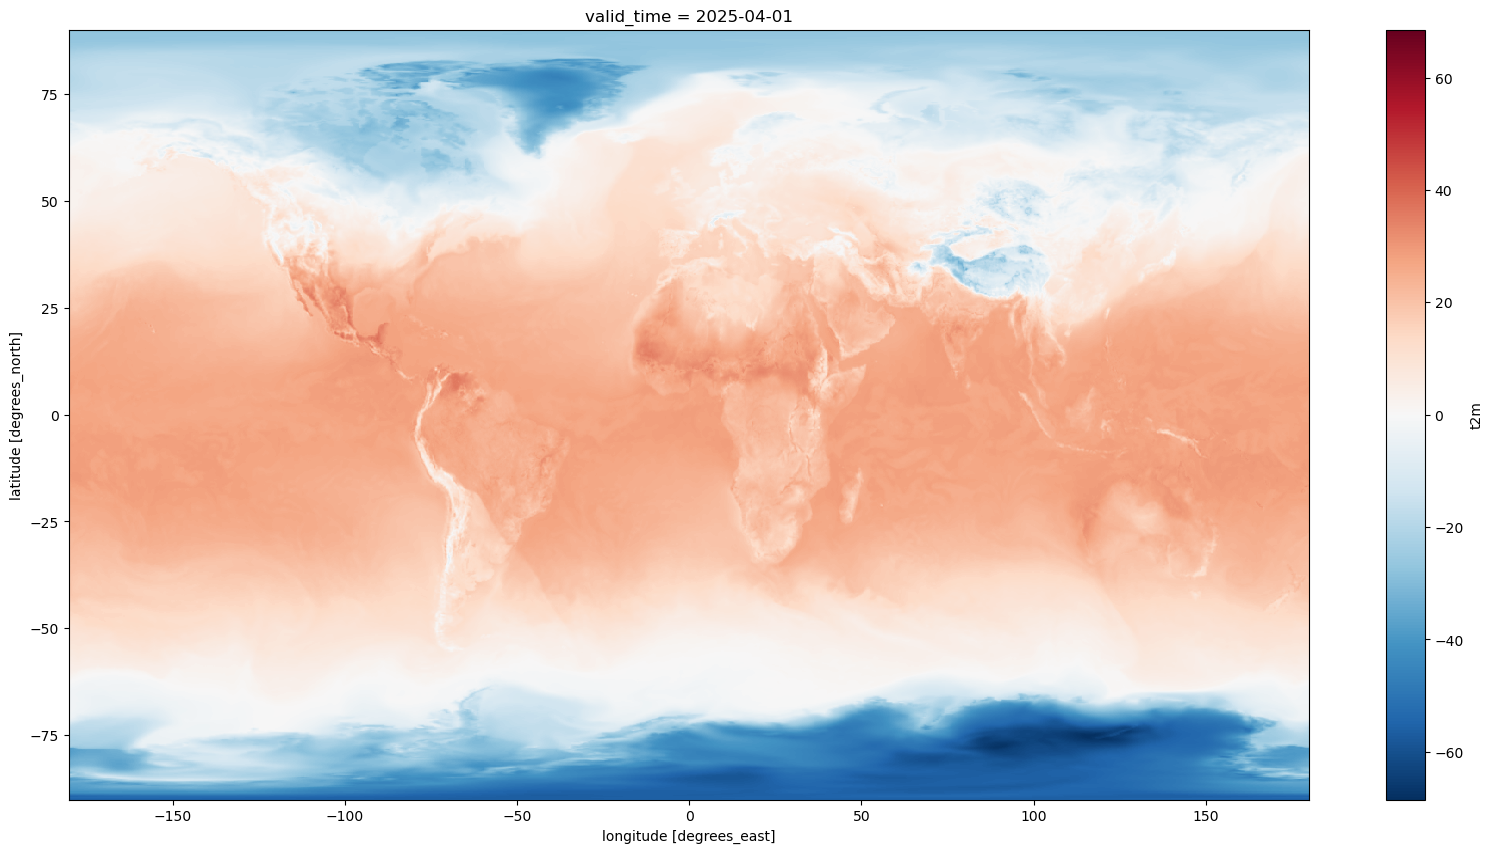

In [100]:
da_T2M_in_C.isel(valid_time=0).plot.imshow(figsize=(20, 10))

#### Visualizing 24-Hour Historical Temperature (ERA5) ¶

This step plots a series of 24 hourly snapshots of 2-meter air temperature (°C)  
from historical ERA5 data (not forecast), displayed in a 4×6 grid of maps.

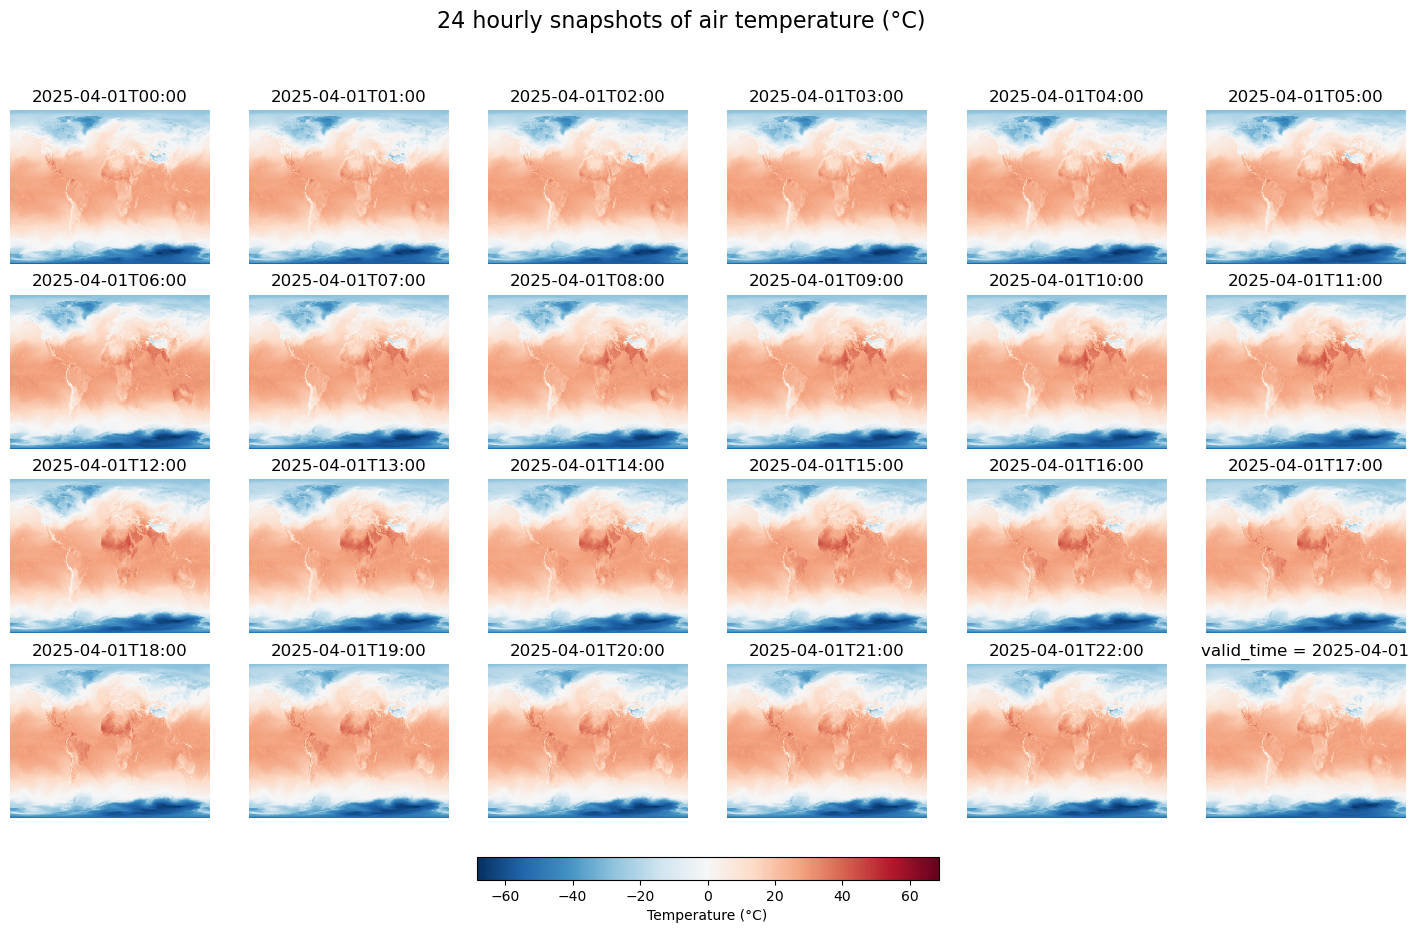

In [101]:
# Select the first 24 hours
data_24h = da_T2M_in_C.isel(valid_time=slice(0, 24))

# Create 4x6 grid of subplots (24 plots)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 10))

for i, ax in enumerate(axes.flat):
    data_24h.isel(valid_time=i).plot.imshow(ax=ax, add_colorbar=False)
    ax.set_title(str(data_24h.valid_time[i].values)[:16])
    ax.axis('off')

# Add a single shared colorbar
cbar = fig.colorbar(data_24h.isel(valid_time=0).plot.imshow(add_colorbar=False), ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.03, pad=0.05)
cbar.set_label("Temperature (°C)")

plt.suptitle("24 hourly snapshots of air temperature (°C) ", fontsize=16)

plt.show()

#### 3D visualization of ERA5 temperature dataset

This step renders a 3D data cube of `2-meter air temperature (°C)` over time, latitude, and longitude  
using the `lexcube` interactive widget with a thermal color map.

> The cube enables intuitive exploration of spatiotemporal temperature patterns across the globe

In [103]:
w = lexcube.Cube3DWidget(da_T2M_in_C, cmap="thermal")
w.plot()

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

#### ERA5 Accumulated Weather Variables ¶

This step loads an ERA5 dataset containing two accumulated weather variables:

- **tp** – Total precipitation `in meters`
- **ssrd** – Surface solar radiation downwards `in J/m²`

In [104]:
ds_SSRD_TP = xr.open_dataset(era5_accum_raster_path, chunks={})
ds_SSRD_TP = ds_SSRD_TP.drop_vars("number")
ds_SSRD_TP = ds_SSRD_TP.drop_vars("expver")
ds_SSRD_TP

<xarray.Dataset> Size: 399MB
Dimensions:     (valid_time: 48, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 384B 2025-04-01 ... 2025-04-30T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
Data variables:
    tp          (valid_time, latitude, longitude) float32 199MB dask.array<chunksize=(16, 241, 480), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 199MB dask.array<chunksize=(16, 241, 480), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-08T18:36 GRIB to CDM+CF via cfgrib-0.9.1...

### 3D visualization of ERA5 precipitation dataset

This step renders a 3D data cube of total accumulated precipitation (`tp`, in meters)  
over time, latitude, and longitude using the `lexcube` interactive widget with a blue color map.

> The cube enables intuitive exploration of global spatiotemporal precipitation structures and patterns

In [90]:
da_TP = ds_SSRD_TP['tp']
w = lexcube.Cube3DWidget(da_TP, cmap="Blues")
w.plot()

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…

### 3D visualization of ERA5 solar radiation dataset

This step renders a 3D data cube of surface solar radiation downwards (`ssrd`, in J/m²)  
over time, latitude, and longitude using the `lexcube` interactive widget with an inferno color map.

> The cube allows dynamic exploration of global spatiotemporal solar energy distribution

In [91]:
da_SSRD = ds_SSRD_TP['ssrd']
w = lexcube.Cube3DWidget(da_SSRD, cmap="inferno")
w.plot()

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…